In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_validate

# Setting

In [2]:
# path to where we our preprocessed data is
data_file_path = Path("../data")

# path to where we save our model results
model_results_file_path = Path("./model_results")

# target variable
TARGET_VAR = "price_per_dozen"

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso()
}

# Hyperparameter grids
param_grids = {
    "Ridge Regression": {"alpha": [0.01, 0.1, 1, 10, 100]},
    "Lasso Regression": {"alpha": [0.001, 0.01, 0.1, 1, 10]}
}

# Load Dataset
dataset = pd.read_csv(f'{data_file_path}/merged_data.csv', index_col=0)
dataset_scaled = pd.read_csv(f'{data_file_path}/merged_scaled_data.csv', index_col=0)

# Regression

## Original Features

In [3]:
X = dataset[['disaster_cost_adjusted', 'human_outbreaks_per_million', 'covid_hospitalization_per_million', 'infected_flock_cnt', 'infected_h5n1_people_cnt', 'gas_price_per_gallon', 'temp_variance']].copy()
Y = dataset.loc[:, TARGET_VAR:TARGET_VAR] # Extract the target variable (Y)

# List to store all results
results_list = []
scoring = {
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# Loop through models
for name, model in models.items():
    if name in param_grids:  # Apply GridSearchCV if hyperparameters exist
        grid_search = GridSearchCV(
            model, param_grids[name], 
            cv=5, scoring=scoring, refit="R2", n_jobs=-1, verbose=1
        )
        grid_search.fit(X, Y)

        # Get best hyperparameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        # Extract cross-validation results from GridSearchCV
        cv_results = grid_search.cv_results_
        best_index = grid_search.best_index_

        # Extract precomputed metrics
        mean_mae = -cv_results["mean_test_MAE"][best_index]
        std_mae = cv_results["std_test_MAE"][best_index]
        mean_mse = -cv_results["mean_test_MSE"][best_index]
        std_mse = cv_results["std_test_MSE"][best_index]
        mean_rmse = np.sqrt(mean_mse)
        std_rmse = np.sqrt(std_mse)  # Direct RMSE std calculation
        mean_r2 = cv_results["mean_test_R2"][best_index]
        std_r2 = cv_results["std_test_R2"][best_index]

    else:
        model.fit(X, Y)  # Train model directly if no hyperparameters
        best_params = "N/A"
        best_model = model

        # Perform 5-fold CV only if GridSearchCV was not used
        scores = cross_validate(best_model, X, Y, cv=5, scoring=scoring)

        # Extract metrics from cross-validation results
        mean_mae = -np.mean(scores["test_MAE"])
        std_mae = np.std(scores["test_MAE"])
        mean_mse = -np.mean(scores["test_MSE"])
        std_mse = np.std(scores["test_MSE"])
        mean_rmse = np.sqrt(mean_mse)
        std_rmse = np.std(np.sqrt(-scores["test_MSE"]))
        mean_r2 = np.mean(scores["test_R2"])
        std_r2 = np.std(scores["test_R2"])

    # Store results
    results_list.append({
        'Model': name,
        'Best Params': best_params,
        'MAE': mean_mae,
        'MAE Std': std_mae,
        'RMSE': mean_rmse,
        'RMSE Std': std_rmse,
        'MSE': mean_mse,
        'MSE Std': std_mse,
        'R2': mean_r2,
        'R2 Std': std_r2
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results_list)
df_results.head()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Model,Best Params,MAE,MAE Std,RMSE,RMSE Std,MSE,MSE Std,R2,R2 Std
0,Linear Regression,N/A,0.241090,0.146091,0.435330,0.259650,0.189512,0.248603,-0.519966,0.416523
1,Ridge Regression,{'alpha': 10},0.237533,0.141805,0.433083,0.498745,0.187561,0.248746,-0.513284,0.409282
2,Lasso Regression,{'alpha': 0.001},0.240442,0.145130,0.434552,0.498113,0.188836,0.248116,-0.518070,0.414108


In [4]:
df_results.to_csv(f'{model_results_file_path}/linear_ridge_lasso_cv_result.csv')

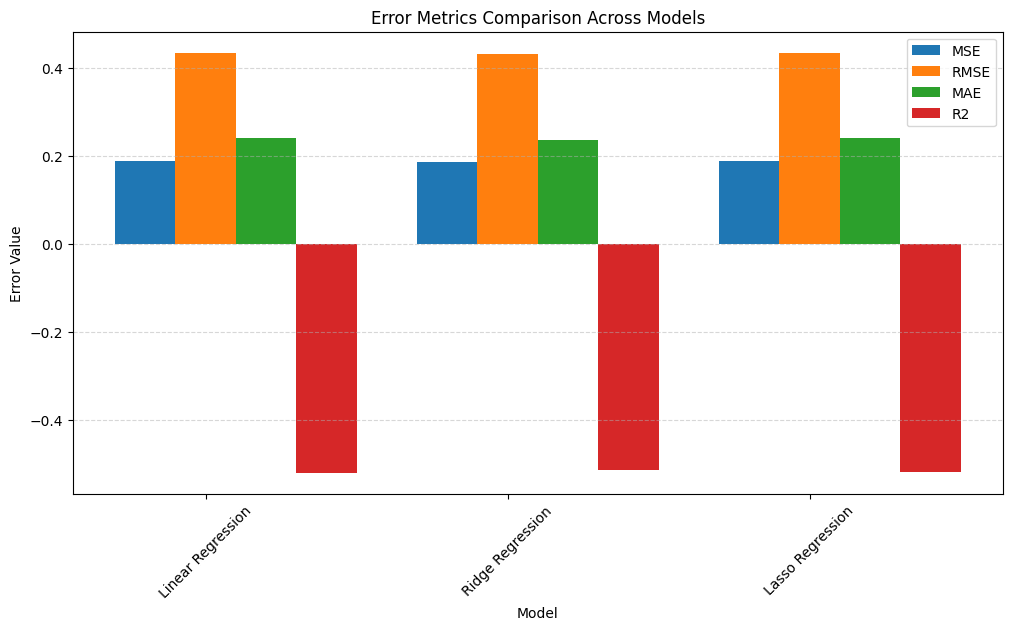

In [5]:
import numpy as np

metrics = ["MSE", "RMSE", "MAE", "R2"]
x = np.arange(len(df_results))  # X-axis positions for models

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i * 0.2, df_results[metric], width=0.2, label=metric)

plt.xlabel("Model")
plt.ylabel("Error Value")
plt.title("Error Metrics Comparison Across Models")
plt.xticks(x + 0.2, df_results["Model"], rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

## Scaled Features

In [6]:
X = dataset_scaled[['disaster_cost_adjusted', 'human_outbreaks_per_million', 'covid_hospitalization_per_million', 'infected_flock_cnt', 'infected_h5n1_people_cnt', 'gas_price_per_gallon', 'temp_variance']].copy()
Y = dataset_scaled.loc[:, TARGET_VAR:TARGET_VAR] # Extract the target variable (Y)

# List to store all results
results_list = []
scoring = {
    "MSE": make_scorer(mean_squared_error, greater_is_better=False),
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# Loop through models
for name, model in models.items():
    if name in param_grids:  # Apply GridSearchCV if hyperparameters exist
        grid_search = GridSearchCV(
            model, param_grids[name], 
            cv=5, scoring=scoring, refit="R2", n_jobs=-1, verbose=1
        )
        grid_search.fit(X, Y)

        # Get best hyperparameters and model
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        # Extract cross-validation results from GridSearchCV
        cv_results = grid_search.cv_results_
        best_index = grid_search.best_index_

        # Extract precomputed metrics
        mean_mae = -cv_results["mean_test_MAE"][best_index]
        std_mae = cv_results["std_test_MAE"][best_index]
        mean_mse = -cv_results["mean_test_MSE"][best_index]
        std_mse = cv_results["std_test_MSE"][best_index]
        mean_rmse = np.sqrt(mean_mse)
        std_rmse = np.sqrt(std_mse)  # Direct RMSE std calculation
        mean_r2 = cv_results["mean_test_R2"][best_index]
        std_r2 = cv_results["std_test_R2"][best_index]

    else:
        model.fit(X, Y)  # Train model directly if no hyperparameters
        best_params = "N/A"
        best_model = model

        # Perform 5-fold CV only if GridSearchCV was not used
        scores = cross_validate(best_model, X, Y, cv=5, scoring=scoring)

        # Extract metrics from cross-validation results
        mean_mae = -np.mean(scores["test_MAE"])
        std_mae = np.std(scores["test_MAE"])
        mean_mse = -np.mean(scores["test_MSE"])
        std_mse = np.std(scores["test_MSE"])
        mean_rmse = np.sqrt(mean_mse)
        std_rmse = np.std(np.sqrt(-scores["test_MSE"]))
        mean_r2 = np.mean(scores["test_R2"])
        std_r2 = np.std(scores["test_R2"])

    # Store results
    results_list.append({
        'Model': name,
        'Best Params': best_params,
        'MAE': mean_mae,
        'MAE Std': std_mae,
        'RMSE': mean_rmse,
        'RMSE Std': std_rmse,
        'MSE': mean_mse,
        'MSE Std': std_mse,
        'R2': mean_r2,
        'R2 Std': std_r2
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results_list)
df_results.head()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Model,Best Params,MAE,MAE Std,RMSE,RMSE Std,MSE,MSE Std,R2,R2 Std
0,Linear Regression,N/A,0.241090,0.146091,0.435330,0.259650,0.189512,0.248603,-0.519966,0.416523
1,Ridge Regression,{'alpha': 10},0.239893,0.145996,0.436279,0.504130,0.190339,0.254147,-0.512194,0.400157
2,Lasso Regression,{'alpha': 0.001},0.240808,0.145874,0.435148,0.499043,0.189354,0.249044,-0.517265,0.415509


# SHAP

In [7]:
import shap
from sklearn.model_selection import train_test_split

In [8]:
X = dataset[['disaster_cost_adjusted', 'human_outbreaks_per_million', 'covid_hospitalization_per_million', 'infected_flock_cnt', 'infected_h5n1_people_cnt', 'gas_price_per_gallon', 'temp_variance']].copy()
Y = dataset.loc[:, TARGET_VAR:TARGET_VAR] # Extract the target variable (Y)
X_train, X_test, y_train, y_test = train_test_split(
  X,Y , random_state=104,test_size=0.2, shuffle=True)

In [9]:
# Create Best Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [10]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)


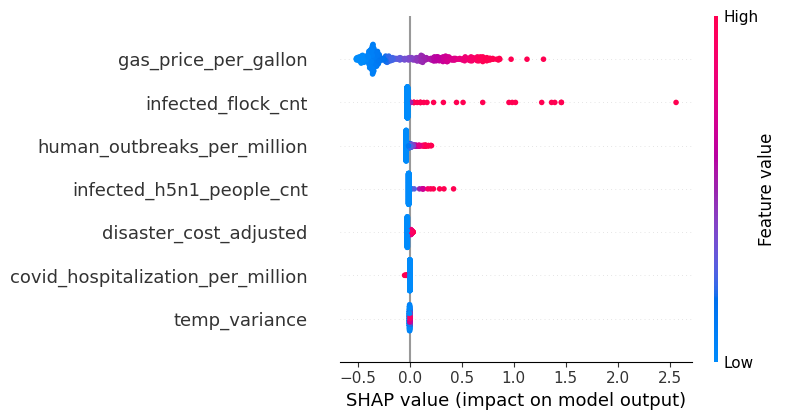

In [11]:
shap.summary_plot(shap_values, X_train)


# Example Prediction

In [17]:
X_example = X.tail(5)

In [19]:
X_example

,disaster_cost_adjusted,human_outbreaks_per_million,covid_hospitalization_per_million,infected_flock_cnt,infected_h5n1_people_cnt,gas_price_per_gallon,temp_variance
536,11.290414,0.0,0.0,2.0,0.0,3.478,14.476570
537,10.442569,0.0,0.0,6.0,0.0,3.412,4.655387
538,3.653720,0.0,0.0,23.0,0.0,3.315,8.545652
539,3.653720,0.0,0.0,82.0,0.0,3.277,5.038165
540,0.000000,0.0,0.0,32.0,6.0,3.342,6.381190


In [18]:
model.predict(X_example)

array([[1.99129539],
       [2.08263476],
       [2.54790501],
       [4.39036573],
       [2.83113264]])

In [15]:
Y.tail(5)

,price_per_dozen
536,3.821
537,3.370
538,3.649
539,4.146
540,4.953


price_per_dozen    4.953
dtype: float64